<h1>Trabalho Prático 1 - Daniel Pimentel Kansaon</h1>


O trabalho consiste na aplicação de algoritmos supervisionados comparando ao todo 6 métodos:

- **Naive Bayes**: Apenas um experimento para servir de baseline.
- **Decision Tree**: Variar a altura máxima da árvore (incluindo permitir altura ilimitada) e mostrar os resultados graficamente.
- **SVM**: Avaliar os kernels linear, sigmoid, polinomial e RBF.
- **k-NN**: Variar o número k de vizinhos e mostrar os resultados graficamente.
- **Random Forest**: Variar o número de árvores e mostrar os resultados graficamente.
- **Gradient Tree Boosting**: Variar o número de iterações e mostrar os resultados graficamente.

Os métodos serão testados em um problema de classificação binária (0 - 1) de candidatos a exoplanetas encontrados pela sonda espacial Kepler da NASA. Um exoplaneta é um planeta fora do sistema solar (i.e. que não orbita o sol). A sonda primeiro identifica sinais de possíıveis exoplanetas, chamados de Kepler Object of Interest (KOI). Porem nem todos os KOIs são de fato exoplanetas, alguns se tratam de "Falsos Positivos" de origens diversas. A tarefa é então classificar os KOIs entre exoplanetas
confirmados e "Falsos Positivos". Cada observação corresponde a um KOI e as features são características estimadas de cada (possível) exoplaneta (tamanho, temperatura, features da estrela hospedeira, etc).


In [1]:
#Adicionando as referências que serão usadas durante o trabalho
import pandas as pd
import numpy as np
import random

from sklearn.model_selection import StratifiedKFold
from sklearn import feature_selection
import matplotlib.pyplot as plt
from sklearn import metrics
import matplotlib as mpl
import statistics

#Metodos
from sklearn import svm
from sklearn import neighbors #K-nn
from sklearn import ensemble #Random Forest
from sklearn.naive_bayes import GaussianNB #Naive Bayes
from sklearn.naive_bayes import MultinomialNB #Naive Bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree


In [2]:
# As constantes do projeto estão adicionadas aqui.

# Caminho arquivo com os dados
FILE_PATH = "koi_data.csv"

#Quantidade de folds que será utilizado para a etapa de Cross-Validation
K_FOLD = 5

#Coluna TARGET do arquivo CSV
TARGET = "koi_disposition"

#Coluna que possui o nome do KOI
COLUMN_KOI = "kepoi_name"

## Tratamento nos Dados

Como dito acima, cada observação realizada corresponde a um KOI e as features são características estimadas de cada (possível) exoplaneta (tamanho, temperatura, features da estrela hospedeira, etc).

Assim, nesta etapa serão realizados processamentos nos dados a fim de prepará-los para a execução dos algoritmos.

In [22]:
df = pd.read_csv(FILE_PATH)

# Imprime algumas informacoes basicas sobre os dados
print("Número de linhas: {}".format(df.shape[0]))
print("Número de colunas: {}".format(df.shape[1]))

# Cria a lista de features com base nas colunas do arquivo CSV
features = list(df.columns)

#Remove a coluna target pois ela que está querendo prever.
features.remove(TARGET)

#Remove a coluna de nome, pois não é necessária para a predição
features.remove(COLUMN_KOI)

Número de linhas: 5202
Número de colunas: 43


## Ajustando o Target (rótulos dos dados)

In [25]:
#Porcentagem de [False Positive e Confirmed]
display((df[TARGET].value_counts()/len(df)*100).round(2).to_frame(TARGET +" (%)").T)
df[TARGET] = (df[TARGET] == "CONFIRMED").astype(int)

,FALSE POSITIVE,CONFIRMED
koi_disposition (%),59.55,40.45


## Separação dos dados para a validação cruzada

Nessa parte são separados os dados com base nos folds(5) para a validação cruzada. A partir disto, os algoritmos irão usar essa separação para os testes.

In [26]:
#Criando os vetores de treino e validacao
x_train = []
y_train = []
x_validation = []
y_validation = []

#Selecionando as features
skb = feature_selection.SelectKBest(feature_selection.f_classif, 41)
skb = skb.fit(df[features], df[TARGET])

#separa o X (são os exemplos) e o Y é o rótulo [0 ou 1]
X = df
Y = df[TARGET]

#Aqui é feito a separação dos dados em K_FOLD = 5.
data_kfold = StratifiedKFold(n_splits=K_FOLD, shuffle=True)
data_kfold.get_n_splits(X, Y)


#Nessa parte é lido os folds e armazenado nas listas.
#Exemplo: x_train [ fold1, fold2, fold3, fold4, fold5 ]

for train_index, test_index in data_kfold.split(X, Y):
    x_train.append(skb.transform(df.loc[train_index, features]))
    x_validation.append(skb.transform(df.loc[test_index, features]))
    y_train.append(df.loc[train_index, TARGET])
    y_validation.append(df.loc[test_index, TARGET])    

In [27]:
#Método para calcular as principais métricas dos classificadores
def calc_important_metrics(y_val, y_pred):    
    classes = ["Confirmed", "False Positive"]
    print(metrics.classification_report(y_val, y_pred, [0, 1], classes))    

In [28]:
#Método para plotar a curva ROC
def calc_roc(y_val, y_proba):
    fpr, tpr, _ = metrics.roc_curve(y_val, y_proba)

    plt.figure(figsize=(6, 6))
    lw = 2
    plt.plot(fpr, tpr, color='royalblue',lw=2)
    plt.plot([0, 1], [0, 1], color='Black', lw=2, ls='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.show()

In [29]:
#Plota o gráfico da acurácia no treino x acurácia na validação
def plot_accuracyXparams(vX, vYTrain, xYtest, label):    
    plt.plot(vX, vYTrain, 'r--', label="train")
    plt.plot(vX, xYtest, color='royalblue',lw=2, label="validation")
    plt.xlabel(label)
    plt.ylabel('Accuracy')
    plt.title('Parameters x Accuracy')
    plt.legend(loc='upper left')
    plt.show()    

In [30]:
def show_results(clf):       
    y_pred = []
    y_proba = []
    y_val = []

#Obtêm todos os valores da validação de cada FOLD para calcular as métricas
    for i in range(0, K_FOLD):   
        y_pred.extend(clf.predict(x_validation[i]))
        y_proba.extend(clf.predict_proba(x_validation[i])[:, 1])
        y_val.extend(y_validation[i])
    
    #Plotando resultados            
    calc_important_metrics(y_val, y_pred)
    calc_roc(y_val, y_proba)

## Resultados

Nesta etapa serão apresentados os resultados dos classificadores na tarefa de classificar os exoplanetas. Vale ressaltar que foi utilizado validação cruzada de 5 folds/partições. Além do mais, foram plotados gráficos apenas para os melhores parâmetros de cada algoritmo.

## 1 - Naive Bayes

O algoritmo Naive Bayes é o algoritmo mais simples abordado no trabalho, sendo utilizado como baseline no trabalho. Abaixo temos os resultados. De maneira geral, o algoritmo apresentou uma acurácia de 79%.

In [11]:
def calc_naivebayes():
    train_acc = []
    val_acc = []
            
    gnb = GaussianNB()
    
    for i in range(0, K_FOLD):            
        gnb = gnb.fit(x_train[i], y_train[i]) #Treino
        train_acc.append(gnb.score(x_train[i], y_train[i]))
        val_acc.append(gnb.score(x_validation[i], y_validation[i]))      
          
    print("Média da Acurácia na treino: {:.3}".format(np.average(train_acc)))
    print("Média da Acurácia na validação: {:.3}".format(np.average(val_acc)))
    print("Desvio Padrão da Acurácia na treino: {:.3}".format(statistics.stdev(train_acc)))
    print("Desvio Padrão da Acurácia na validação: {:.3}".format(statistics.stdev(val_acc)))      
    
    return gnb

In [12]:
gnb = calc_naivebayes()

Média da Acurácia na treino: 0.799
Média da Acurácia na validação: 0.8
Desvio Padrão da Acurácia na treino: 0.00652
Desvio Padrão da Acurácia na validação: 0.00941


**1.1 - Gráficos - Naive Bayes**

                precision    recall  f1-score   support

     Confirmed       0.98      0.68      0.80      3098
False Positive       0.68      0.98      0.80      2104

     micro avg       0.80      0.80      0.80      5202
     macro avg       0.83      0.83      0.80      5202
  weighted avg       0.86      0.80      0.80      5202



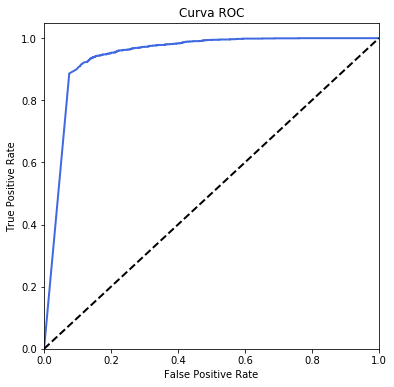

In [13]:
#Exibindo detalhes graficamente
show_results(gnb)

## 2 - Decision Tree

Neste algoritmo foram variados parâmetros relacionados a altura da árvore, 30, 10, 8 e 5, respectivamente. Ao realizar as variações, observou-se que, ao diminuir a profundidade máxima da árvore a acurácia aumenta. Isso ocorre pois, uma árvore muito extensa acaba decorando os dados de treino, logo, na validação, o resultado não é tão bom quanto no treino (overfitting). Os gráficos abaixo exibem a variação da acurácia com base nas variações.

De maneira geral:
- O algoritmo apresentou uma boa precisão para o problema, alcançando uma acurácia de 95,5%
- O melhor parâmetro foi: 5 graus de profundidade máxima. Ao observar o último gráfico, observa-se que selecionado a altura 5, o algoritmo tinha uma taxa de acerto aceitavel no treino e uma boa taxa no teste. Isso confirma que nesse ponto, o algoritmo estava generalizando. A partir desse valor a precisão na validação diminui e aumenta apenas no treino.

In [14]:
def calc_decision_tree(max_depth):
    train_acc = []
    val_acc = []
    
    clf = DecisionTreeClassifier(max_depth=max_depth)
    
    for i in range(0, K_FOLD):          
        clf = clf.fit(x_train[i], y_train[i])  
        train_acc.append(clf.score(x_train[i], y_train[i]))
        val_acc.append(clf.score(x_validation[i], y_validation[i]))        

    print("Média da Acurácia na treino: {:.3}".format(np.average(train_acc)))
    print("Média da Acurácia na validação: {:.3}".format(np.average(val_acc)))
    print("Desvio Padrão da Acurácia na treino: {:.3}".format(statistics.stdev(train_acc)))
    print("Desvio Padrão da Acurácia na validação: {:.3}".format(statistics.stdev(val_acc)))
    
    return clf, np.average(train_acc), np.average(val_acc)

**2.1 - Variando Parâmetros**

In [15]:
v_decision_acc_train = []
v_decision_acc_test = []

clf, acc_train, acc_test = calc_decision_tree(30)
v_decision_acc_train.append(acc_train)
v_decision_acc_test.append(acc_test)

Média da Acurácia na treino: 1.0
Média da Acurácia na validação: 0.951
Desvio Padrão da Acurácia na treino: 0.0
Desvio Padrão da Acurácia na validação: 0.00416


In [16]:
clf, acc_train, acc_test = calc_decision_tree(10)
v_decision_acc_train.append(acc_train)
v_decision_acc_test.append(acc_test)

Média da Acurácia na treino: 0.991
Média da Acurácia na validação: 0.953
Desvio Padrão da Acurácia na treino: 0.00103
Desvio Padrão da Acurácia na validação: 0.00458


In [17]:
clf, acc_train, acc_test = calc_decision_tree(8)
v_decision_acc_train.append(acc_train)
v_decision_acc_test.append(acc_test)

Média da Acurácia na treino: 0.987
Média da Acurácia na validação: 0.951
Desvio Padrão da Acurácia na treino: 0.00245
Desvio Padrão da Acurácia na validação: 0.00512


In [18]:
clf, acc_train, acc_test = calc_decision_tree(5)
v_decision_acc_train.append(acc_train)
v_decision_acc_test.append(acc_test)

Média da Acurácia na treino: 0.963
Média da Acurácia na validação: 0.955
Desvio Padrão da Acurácia na treino: 0.00201
Desvio Padrão da Acurácia na validação: 0.00727


**2.2 - Gráficos - Decision Tree**

                precision    recall  f1-score   support

     Confirmed       0.98      0.96      0.97      3098
False Positive       0.94      0.97      0.96      2104

     micro avg       0.96      0.96      0.96      5202
     macro avg       0.96      0.96      0.96      5202
  weighted avg       0.96      0.96      0.96      5202



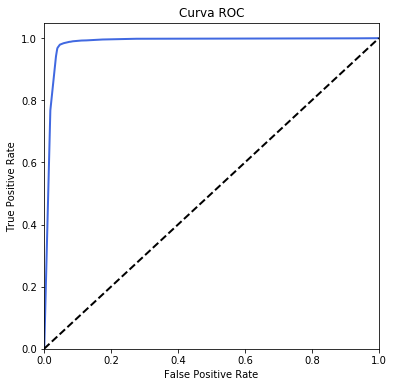

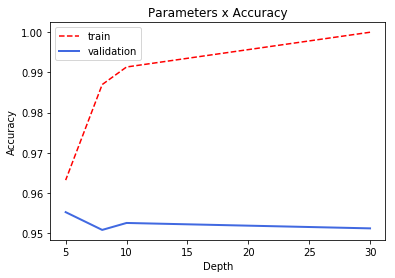

In [19]:
show_results(clf)
plot_accuracyXparams([30, 10, 8, 5], v_decision_acc_train, v_decision_acc_test, "Depth")

## 3 - Support Vector Machine

In [40]:
def calc_svm(kernel):
    train_acc = []
    val_acc = []
    c = 1
    clf = svm.SVC(c, kernel, gamma="scale")
    
    for i in range(0, K_FOLD):          
        print("Fold " + str(i))
        clf = clf.fit(x_train[i], y_train[i])  
        train_acc.append(clf.score(x_train[i], y_train[i]))
        val_acc.append(clf.score(x_validation[i], y_validation[i]))
   
    print("Média da Acurácia na treino: {:.3}".format(np.average(train_acc)))
    print("Média da Acurácia na validação: {:.3}".format(np.average(val_acc)))
    print("Desvio Padrão da Acurácia na treino: {:.3}".format(statistics.stdev(train_acc)))
    print("Desvio Padrão da Acurácia na validação: {:.3}".format(statistics.stdev(val_acc)))   
    
    return clf, np.average(train_acc), np.average(val_acc)

**3.1 - Parâmetros**

In [ ]:
v_svm_acc_train = []
v_svm_acc_test = []

clf, acc_train, acc_test = calc_svm("linear")
v_svm_acc_train.append(acc_train)
v_svm_acc_test.append(acc_test)

Fold 0
Fold 1


In [36]:
clf, acc_train, acc_test = calc_svm("sigmoid")
v_svm_acc_train.append(acc_train)
v_svm_acc_test.append(acc_test)

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Média da Acurácia na treino: 0.553
Média da Acurácia na validação: 0.552
Desvio Padrão da Acurácia na treino: 0.00438
Desvio Padrão da Acurácia na validação: 0.00419


In [42]:
clf, acc_train, acc_test = calc_svm("poly")
v_svm_acc_train.append(acc_train)
v_svm_acc_test.append(acc_test)

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Média da Acurácia na treino: 0.596
Média da Acurácia na validação: 0.596
Desvio Padrão da Acurácia na treino: 5.25e-05
Desvio Padrão da Acurácia na validação: 0.00021


In [41]:
clf, acc_train, acc_test = calc_svm("rbf")
v_svm_acc_train.append(acc_train)
v_svm_acc_test.append(acc_test)

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Média da Acurácia na treino: 0.682
Média da Acurácia na validação: 0.681
Desvio Padrão da Acurácia na treino: 0.00463
Desvio Padrão da Acurácia na validação: 0.0116


## 4 - k-NN

Neste algoritmo foi variado a quantidade de vizinhos, ou seja, a quantidade de vizinhos necessários para classificar um ponto para uma classe ou não. De maneira geral: 

- O algoritmo apresentou uma precisão máxima de 78,9%
- Ao aumentar a quantidade de vizinhos a precisão foi aumentando. A melhor escolha foi de 30
- É possível observar nos gráficos que ao aumentar a variável (k), ou seja, a quantidade de vizinhos, a precisão no treino diminui, mas em compensação a precisão no teste aumenta. Isso estabiliza com k = 10, mas a partir de k= 30 o valor a precisão na validação e no treino se aproxima, isso é um bom sinal de que o algoritmo não está decorando os dados, sendo possível generalizar. Por isso a escolha desse valor.

In [21]:
def calc_k_nn(k): 
    train_acc = []
    val_acc = []
    
    print("K = {}".format(k))             
    clf = neighbors.KNeighborsClassifier(n_neighbors=k) 
    
    for i in range(0, K_FOLD):          
        clf = clf.fit(x_train[i], y_train[i])  
        train_acc.append(clf.score(x_train[i], y_train[i]))
        val_acc.append(clf.score(x_validation[i], y_validation[i]))

    print("Média da Acurácia na treino: {:.3}".format(np.average(train_acc)))
    print("Média da Acurácia na validação: {:.3}".format(np.average(val_acc)))
    print("Desvio Padrão da Acurácia na treino: {:.3}".format(statistics.stdev(train_acc)))
    print("Desvio Padrão da Acurácia na validação: {:.3}".format(statistics.stdev(val_acc))) 
    
    return clf, np.average(train_acc), np.average(val_acc)

**4.1 - Variando Parâmetros**

In [22]:
v_knn_acc_train = []
v_knn_acc_test = []

clf, acc_train, acc_test = calc_k_nn(5)
v_knn_acc_train.append(acc_train)
v_knn_acc_test.append(acc_test)

K = 5
Média da Acurácia na treino: 0.846
Média da Acurácia na validação: 0.783
Desvio Padrão da Acurácia na treino: 0.00419
Desvio Padrão da Acurácia na validação: 0.015


In [23]:
clf, acc_train, acc_test = calc_k_nn(10)
v_knn_acc_train.append(acc_train)
v_knn_acc_test.append(acc_test)

K = 10
Média da Acurácia na treino: 0.826
Média da Acurácia na validação: 0.788
Desvio Padrão da Acurácia na treino: 0.00253
Desvio Padrão da Acurácia na validação: 0.0156


In [40]:
clf, acc_train, acc_test = calc_k_nn(30)
v_knn_acc_train.append(acc_train)
v_knn_acc_test.append(acc_test)

K = 30
Média da Acurácia na treino: 0.799
Média da Acurácia na validação: 0.789
Desvio Padrão da Acurácia na treino: 0.00314
Desvio Padrão da Acurácia na validação: 0.0124


**4.2 - Gráficos - k-NN**

                precision    recall  f1-score   support

     Confirmed       0.86      0.78      0.82      3098
False Positive       0.72      0.82      0.77      2104

     micro avg       0.80      0.80      0.80      5202
     macro avg       0.79      0.80      0.79      5202
  weighted avg       0.81      0.80      0.80      5202



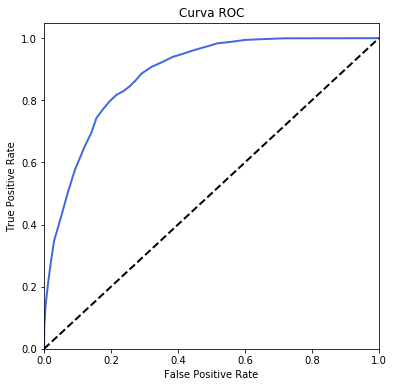

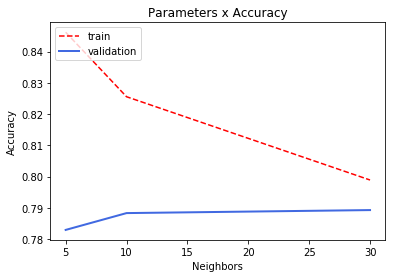

In [25]:
show_results(clf)
plot_accuracyXparams([5, 10, 30], v_knn_acc_train, v_knn_acc_test, "Neighbors")

## 5 - Random Forest

Neste algoritmo foram variados os parâmetros de: quantidade de árvores e tamanho máximo da árvore. De maneira geral, o algoritmo apresentou uma boa precisão de 96%.

De maneira geral:

- Os parâmetros: n_estimators=10, max_depth=10, foram os melhores.
- É interessante que se utilizarmos uma maior quantidade de árvores o algoritmo atinge uma precisão maior que 96%, mas em contrapartida, o modelo em vez de generalizar, decora o dado. Isso não é bom. Por isso, foi escolhido parâmetros com menos precisão, mas que não decora os dados. No último gráfico é possível observar essa variação.
- Além disto, o random forest demonstra ser um bom classificador, ao observar a curva ROC.

In [26]:
def calc_randomforest(N, max_depth):
    train_acc = []
    val_acc = []
    
    clf = ensemble.RandomForestClassifier(n_estimators=N, max_depth=max_depth)
    
    for i in range(0, K_FOLD):          
        clf = clf.fit(x_train[i], y_train[i])  
        train_acc.append(clf.score(x_train[i], y_train[i]))
        val_acc.append(clf.score(x_validation[i], y_validation[i]))        

    print("Média da Acurácia na treino: {:.3}".format(np.average(train_acc)))
    print("Média da Acurácia na validação: {:.3}".format(np.average(val_acc)))
    print("Desvio Padrão da Acurácia na treino: {:.3}".format(statistics.stdev(train_acc)))
    print("Desvio Padrão da Acurácia na validação: {:.3}".format(statistics.stdev(val_acc)))
        
    return clf, np.average(train_acc), np.average(val_acc)

**5.1 - Variando Parâmetros**

In [27]:
v_random_acc_train = []
v_random_acc_test = []

clf, acc_train, acc_test = calc_randomforest(50, None)
v_random_acc_train.append(acc_train)
v_random_acc_test.append(acc_test)

Média da Acurácia na treino: 1.0
Média da Acurácia na validação: 0.97
Desvio Padrão da Acurácia na treino: 0.000107
Desvio Padrão da Acurácia na validação: 0.00398


In [28]:
clf, acc_train, acc_test = calc_randomforest(25, 10)
v_random_acc_train.append(acc_train)
v_random_acc_test.append(acc_test)

Média da Acurácia na treino: 0.991
Média da Acurácia na validação: 0.967
Desvio Padrão da Acurácia na treino: 0.000844
Desvio Padrão da Acurácia na validação: 0.00497


In [29]:
clf, acc_train, acc_test = calc_randomforest(10, 10)
v_random_acc_train.append(acc_train)
v_random_acc_test.append(acc_test)

Média da Acurácia na treino: 0.989
Média da Acurácia na validação: 0.963
Desvio Padrão da Acurácia na treino: 0.00121
Desvio Padrão da Acurácia na validação: 0.00753


**5.2 - Gráficos**

                precision    recall  f1-score   support

     Confirmed       0.99      0.98      0.99      3098
False Positive       0.97      0.99      0.98      2104

     micro avg       0.98      0.98      0.98      5202
     macro avg       0.98      0.98      0.98      5202
  weighted avg       0.98      0.98      0.98      5202



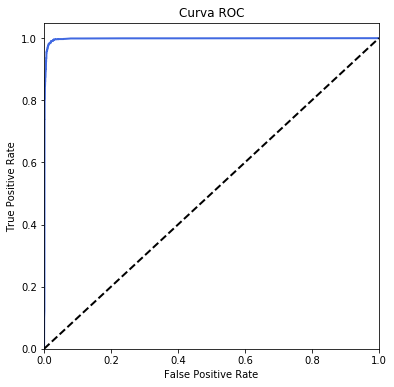

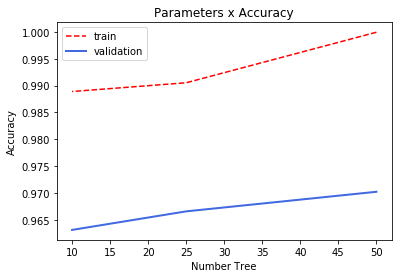

In [30]:
show_results(clf)
plot_accuracyXparams([50, 25, 10], v_random_acc_train, v_random_acc_test, "Number Tree")

## 6 - Gradiente Tree Boosting

Neste algoritmo, variou-se o parâmetro de iteração (n_estimators). De maneira geral, o algoritmo apresentou um excelente resultado 96,4% de acurácia. O melhor parâmetro para o algoritmo foi: n_estimators = 30.

No último gráfico, é possível observar que apartir de n_estimators = 30, a precisão na validação não cresce mais, somente a validação no treino, ou seja, começa o overfitting. Assim, escolheu-se 30 como melhor parâmetro.

In [31]:
def calc_gradient_tree_boosting(n_estimators):
    train_acc = []
    val_acc = []
    
    clf = clf = ensemble.GradientBoostingClassifier(n_estimators=n_estimators)
    
    for i in range(0, K_FOLD):          
        clf = clf.fit(x_train[i], y_train[i])  
        train_acc.append(clf.score(x_train[i], y_train[i]))
        val_acc.append(clf.score(x_validation[i], y_validation[i]))        

    print("Média da Acurácia na treino: {:.3}".format(np.average(train_acc)))
    print("Média da Acurácia na validação: {:.3}".format(np.average(val_acc)))
    print("Desvio Padrão da Acurácia na treino: {:.3}".format(statistics.stdev(train_acc)))
    print("Desvio Padrão da Acurácia na validação: {:.3}".format(statistics.stdev(val_acc)))
    
    return clf, np.average(train_acc), np.average(val_acc)

**6.1 - Variando Parâmetros**

In [32]:
v_boosting_train = []
v_boosting_test = []

clf, acc_train, acc_test = calc_gradient_tree_boosting(5)
v_boosting_train.append(acc_train)
v_boosting_test.append(acc_test)

Média da Acurácia na treino: 0.948
Média da Acurácia na validação: 0.943
Desvio Padrão da Acurácia na treino: 0.00251
Desvio Padrão da Acurácia na validação: 0.00826


In [33]:
clf, acc_train, acc_test = calc_gradient_tree_boosting(15)
v_boosting_train.append(acc_train)
v_boosting_test.append(acc_test)

Média da Acurácia na treino: 0.962
Média da Acurácia na validação: 0.957
Desvio Padrão da Acurácia na treino: 0.002
Desvio Padrão da Acurácia na validação: 0.00341


Média da Acurácia na treino: 0.971
Média da Acurácia na validação: 0.964
Desvio Padrão da Acurácia na treino: 0.00105
Desvio Padrão da Acurácia na validação: 0.00398


                precision    recall  f1-score   support

     Confirmed       0.98      0.97      0.97      3098
False Positive       0.96      0.97      0.96      2104

     micro avg       0.97      0.97      0.97      5202
     macro avg       0.97      0.97      0.97      5202
  weighted avg       0.97      0.97      0.97      5202



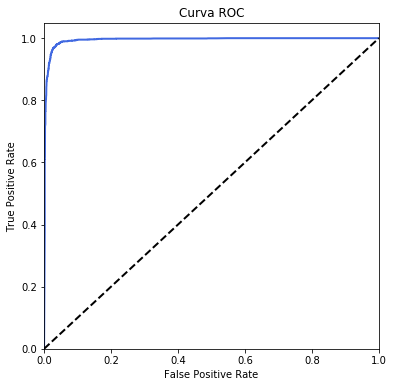

In [34]:
#Melhor parâmetro
clf, acc_train, acc_test = calc_gradient_tree_boosting(30)
v_boosting_train.append(acc_train)
v_boosting_test.append(acc_test)
print("\n")
show_results(clf)

In [35]:
clf, acc_train, acc_test = calc_gradient_tree_boosting(200)
v_boosting_train.append(acc_train)
v_boosting_test.append(acc_test)

Média da Acurácia na treino: 0.997
Média da Acurácia na validação: 0.973
Desvio Padrão da Acurácia na treino: 0.000274
Desvio Padrão da Acurácia na validação: 0.00432


**6.2 - Gráficos**

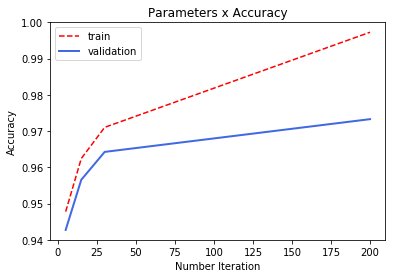

In [36]:
plot_accuracyXparams([5, 15, 30, 200], v_boosting_train, v_boosting_test, "Number Iteration")

## Conclusão

Ao observar os resultados dos algoritmos, pode-se afirmar que de maneira geral, os algoritmos baseados em árvores de decisão apresentaram os melhores resultados. Abaixo segue a lista dos algoritmos.


- 1º - Gradiente Tree Boosting (96,4%) - (n_estimators=30)
- 2º - Random Forest (96,3%) - (n_estimators=10, max_depth=10)
- 3º - Decision Tree (95,5%) - (k=5)
- 4º - SVM (kernel=)
- 5º - Naive Bayes (79,9%)
- 6º - k-NN (79%) - (n_neighbors=30)

A definição dos melhores algoritmos considerou a acurácia no treino e no teste. Buscando selecionar os parâmetros que permitia que os algoritmos não decorar os dados no treino, ou seja, selecionando os modelos com precisão próxima tanto no treino quanto no teste.

**Gráfico da acurácia dos algoritmos com seus melhores parâmetros**

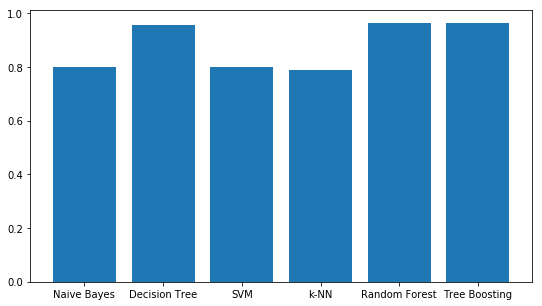

In [44]:
fig, ax = plt.subplots(figsize=(9, 5))
x = [0,1,2,3,4,5]
plt.bar(x, [0.8, 0.955, 0.8, 0.789, 0.963, 0.964])
plt.xticks(x, ('Naive Bayes', 'Decision Tree', 'SVM', 'k-NN', 'Random Forest', 'Tree Boosting'))
plt.show()